### UCB Experiment

In [ ]:
print("UCB Experiment 1")

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
%matplotlib inline
import matplotlib.patheffects as mpe
%run ./Experiment_Functions.ipynb
# load functions for the creation of the different distributions

In [138]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [139]:
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf", "Dates", "Strings", "Discrete_Uniform", "Discrete_Binomial", "Poisson"]

In [140]:
# Define different number of samples for different experiments
n_samples_1e5 = 100000
n_samples_5e4 = 50000
n_samples_5e5 = 500000

In [141]:
# Define the settings of  the 5 different experimental set-ups
list_distributions_1 = 1000*["Discrete_Uniform"] + 1000*["Uniform_Sorted"] 
# list_distributions_1 with n_samples_1e5
list_distributions_2 = 50*["Discrete_Uniform"] +  50*["Uniform_Sorted"]  
# list_distributions_2 with n_samples_5e5
list_distributions_3 = 1000*["Discrete_Uniform"] +  1000*["Uniform_Sorted"] + 1000*["Discrete_Binomial"] + 1000*["Uniform_Reverse_Sorted"]
# list_distributions_3 with n_samples_5e4
list_distributions_4 = 100*["Uniform_Sorted"] +  50*["Poisson"] + 100*["Uniform_Reverse_Sorted"] + 50*["Zipf"]
# list_distributions_4 with n_samples_1e5
list_distributions_5 = 50*["Uniform_Sorted"] +  50*["Poisson"] + 50*["Uniform_Reverse_Sorted"] + 50*["Zipf"] +  50*["Uniform_Reverse_Sorted"] + 50*["Discrete_Uniform"]
# list_distributions_5 with n_samples_1e5

In [142]:
def plot_history(rewards,cum_rewards,chosen_arms):
    print("Arm Counts", chosen_arms)
    fig = plt.figure(figsize=[16,6])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards",fontsize=18)
    ax2.set_ylabel('Reward (multiplied by -1)',fontsize=16)
    ax2.set_xlabel('Iteration',fontsize=16)
    plt.setp(ax2.get_xticklabels(), fontsize=14)
    plt.setp(ax2.get_yticklabels(), fontsize=14)
    labels = list(chosen_arms.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar(chosen_arms.keys(), chosen_arms.values())
    ax3.set_title("Chosen Actions",fontsize=18)
    ax3.set_ylabel('Frequency',fontsize=16)
    ax3.set_xlabel('Action',fontsize=16)
    plt.setp(ax3.get_xticklabels(), fontsize=14)
    plt.setp(ax3.get_yticklabels(), fontsize=14)

In [143]:
def plot_history_iterations(history):
    df = pd.DataFrame.from_records(history,columns=["Iteration","Reward","Algorithm"])
    df["Reward"] = df["Reward"]*(-1)
    groups = df.groupby('Algorithm')
    # Plot
    x_values_1 = [0, 999]
    y_values_1 = [0.005519590000000143,0.005519590000000143]
    x_values_2 = [1000, 2000]
    y_values_2 = [0.0025398040000004585,0.0025398040000004585]
    dict_colors = {"quick_sort":'#1f77b4', "merge_sort":'#ff7f0e', "heap_sort":'#2ca02c'}
    plt.figure(figsize=(16,6))
    for name, group in groups:
        plt.plot(group.Iteration, group.Reward, marker='o', linestyle='', ms=10, alpha = 0.5, label=name, color=dict_colors[name])
    plt.plot(x_values_1, y_values_1, marker = 'o', markersize=10, color = '#1f77b4', linewidth=1, label="Optimal Solution Quick Sort", path_effects= [mpe.Stroke(linewidth=3, foreground='black')], alpha = 0.5)
    plt.plot(x_values_2, y_values_2, marker = 'o', markersize=10, color = '#ff7f0e', linewidth=1, label="Optimal Solution Merge Sort", path_effects= [mpe.Stroke(linewidth=3, foreground='black')], alpha = 0.5)
    
    
    plt.legend(fontsize=26, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Algorithm choices during experiment",fontsize=26)
    plt.ylabel("Runtime in seconds",fontsize=26)
    plt.xlabel("Iteration",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [144]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    for key in arm_rewards:    
        arm_rewards[key] = [i * (-1) for i in arm_rewards[key]]
    #arm_rewards["quick_sort"] = arm_rewards["quick_sort"]*(-1)
    #arm_rewards["merge_sort"] = arm_rewards["merge_sort"]*(-1)
    #arm_rewards["heap_sort"] = arm_rewards["heap_sort"]*(-1)
    plt.figure(figsize=(16,6))
    _, bin_edges_qs = np.histogram(arm_rewards["quick_sort"], density=True)
    _, bin_edges_ms = np.histogram(arm_rewards["merge_sort"], density=True)
    _, bin_edges_hs = np.histogram(arm_rewards["heap_sort"], density=True)
    plt.hist(arm_rewards["quick_sort"], bins=bin_edges_qs, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards["merge_sort"], bins=bin_edges_ms, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards["heap_sort"], bins=bin_edges_hs, alpha = 0.5, label='heap sort')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) ,fontsize=26)
    plt.title("Distribution of runtimes during experiment",fontsize=26)
    plt.ylabel("Frequency",fontsize=26)
    plt.xlabel("Runtime in seconds",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [145]:
# help function to return the humber of consecutive elements in a list 
def count_consec(listrand):
    count=1
    consec_list=[]
    for i in range(len(listrand[:-1])):
        if listrand[i]+1 == listrand[i+1]:
            count+=1
        else:
            consec_list.append(count)
            count=1

    # Account for the last iteration
    consec_list.append(count)     

    return consec_list

In [148]:
def ucb(list_distributions, n_samples, num_consec_elem=1, bound_const=0.001, quantile=0.025, list_length=5):
    total_reward = 0
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}
    ucb_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
    rewards = []
    cum_rewards = []
    num_choices = len(choices)
    bound_const = bound_const
    n_consecutive_list = []
    num_consec_elem = num_consec_elem
    iter_num = 0
    iteration = 0
    history = []
    number_of_restarts = 0
    restarts = []
    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion = create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        for i in (choices_names):
                if arm_counts_temp[i] > 0: 
                    average_reward = np.mean(arm_rewards_temp[i])
                    #print("av_reward", average_reward, "for", choices_names[i])
                    delta_i = bound_const*math.sqrt(2 * math.log(iter_num) / arm_counts_temp[i])
                    #print("delta_i", delta_i, "for", choices_names[i])
                    ucb_values[i] = average_reward + delta_i
                elif arm_counts_temp[i] == 0:
                    ucb_values[i] = 1e500
        choice = max(ucb_values, key=ucb_values.get)
        alg = choices[list(ucb_values.keys()).index(choice)]
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        exeuction_time = time.perf_counter() - start_time
        reward = exeuction_time*(-1)
        arm_rewards[choice].append(reward)
        arm_rewards_temp[choice].append(reward)
        arm_counts[choice] += 1
        arm_counts_temp[choice] += 1
        total_reward += reward
        rewards.append(reward)
        iter_num += 1
        cum_rewards.append(sum(rewards)/len(rewards))
        if len(arm_rewards_temp[choice])>list_length:
            if reward < np.quantile(arm_rewards_temp[choice][:-1], quantile) or reward > np.quantile(arm_rewards_temp[choice][:-1], (1-quantile)):
                n_consecutive_list.append(n)
                if any(i >= num_consec_elem for i in count_consec(n_consecutive_list)):
                    number_of_restarts += 1
                    arm_rewards_temp = {"quick_sort": [], "merge_sort": [], "heap_sort": []}  
                    arm_counts_temp = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0}  
                    n_consecutive_list = []
                    iter_num = 0
                    restarts.append(iteration)
        iteration+=1
        history.append([iteration, reward,choice])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history, number_of_restarts, restarts

# For each setting we are going  to try out different values fo the parameters num_consec_elem and quantile:
### num_consec_elem = 1,3,5
### quantile = 0.05, 0.025, 0.005

## Setting 1:
### list_distributions_1 = 1000*["Discrete_Uniform"] + 1000*["Uniform_Sorted"] 
### list_distributions_1 with n_samples_1e5

#### num_consec_elem = 1, quantile = 0.05

Total reward -10.067070499992042
Number of restarts 192


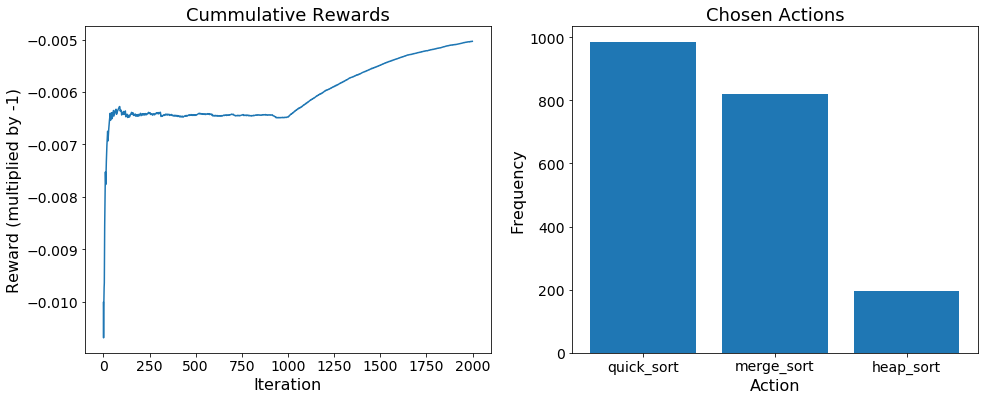

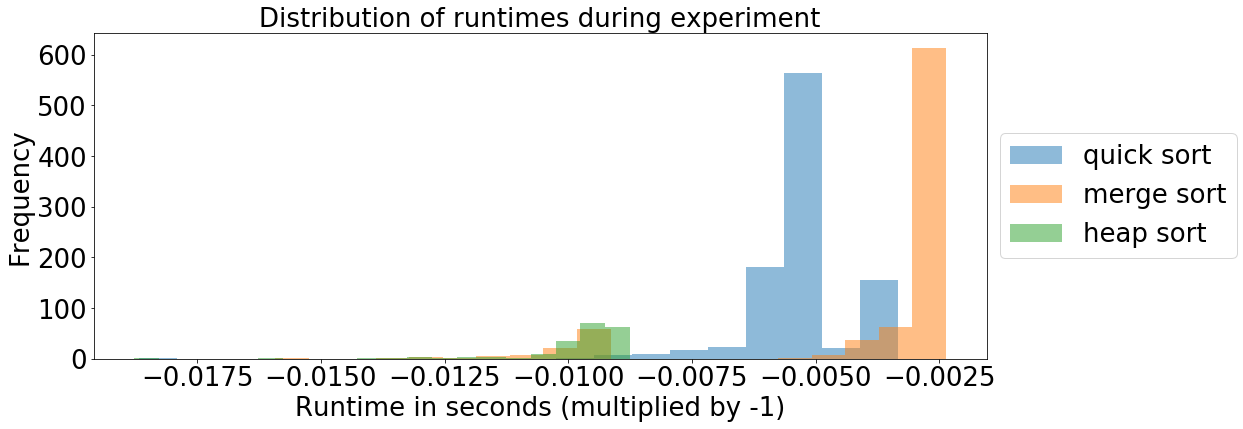

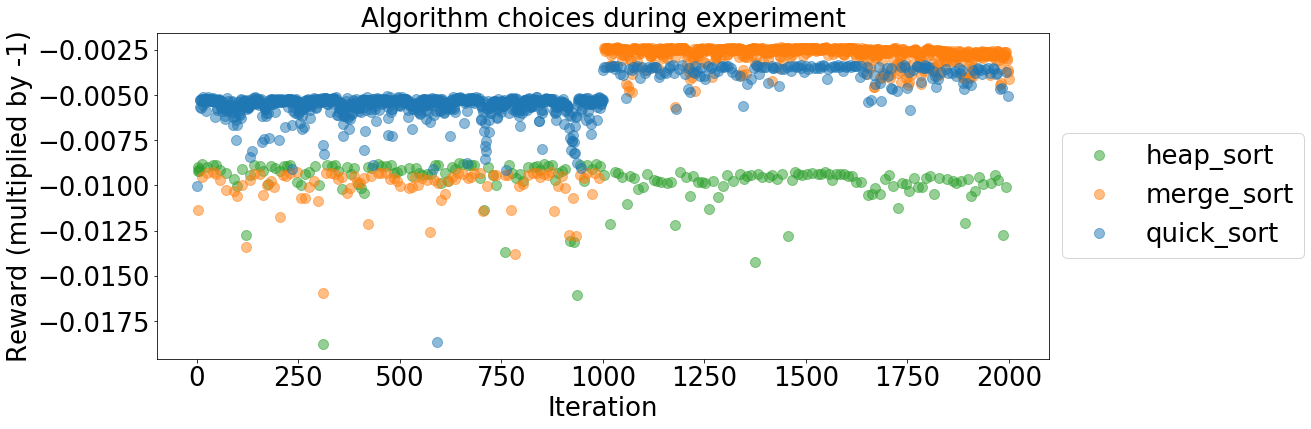

In [149]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 1,quantile = 0.05)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 1, quantile = 0.025

Total reward -9.762057699996149
Number of restarts 176


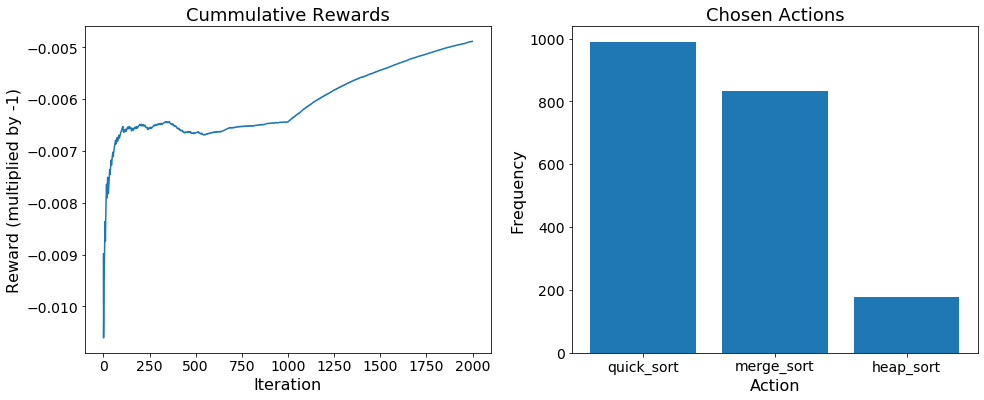

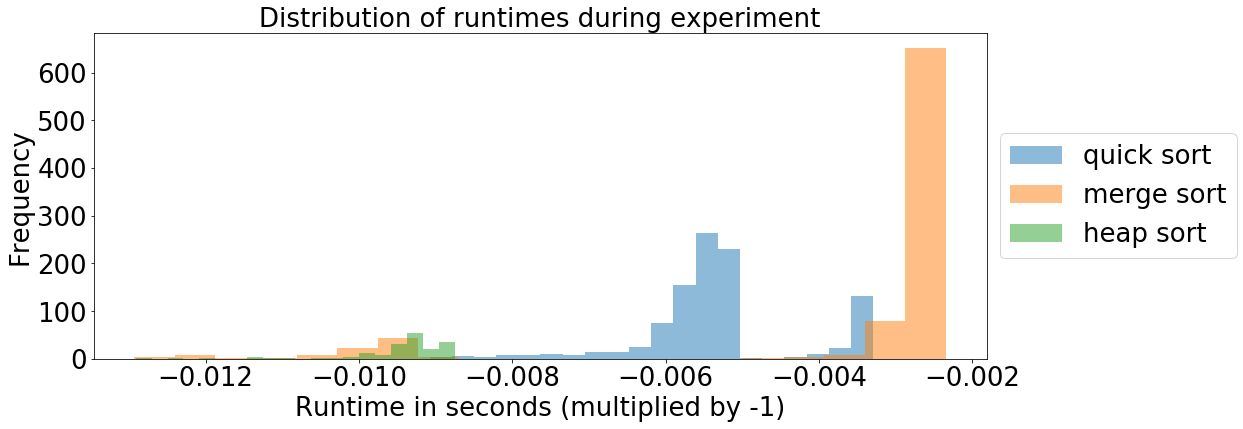

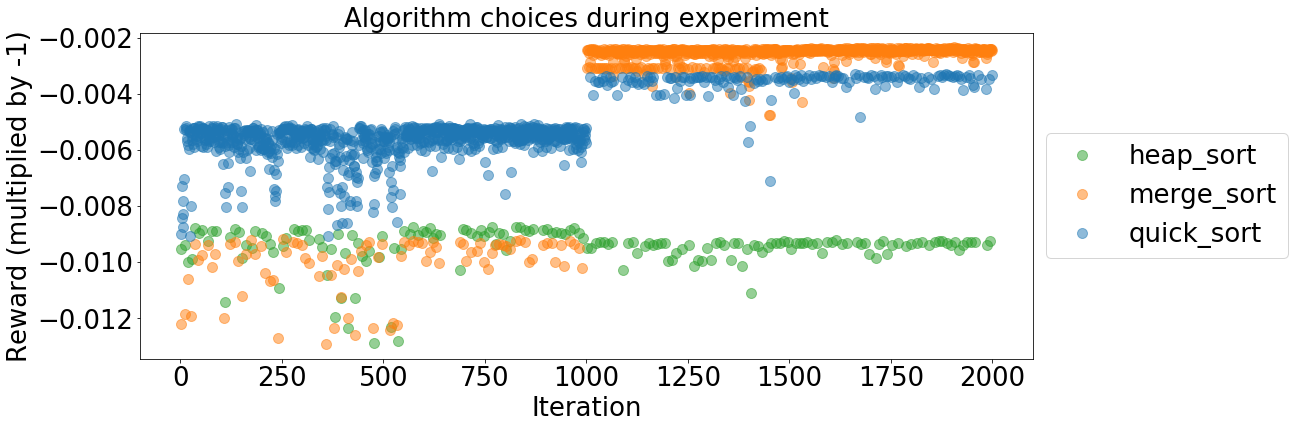

In [150]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 1,quantile = 0.025)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 1, quantile = 0.005

Total reward -9.251627700021345
Number of restarts 158


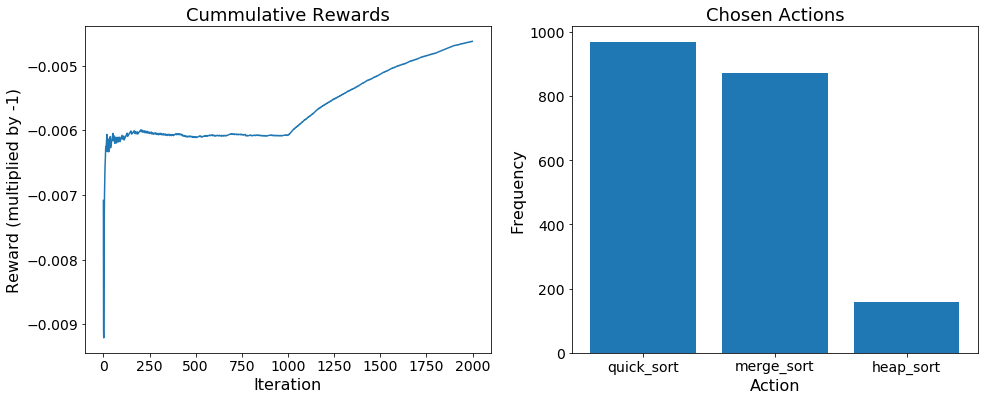

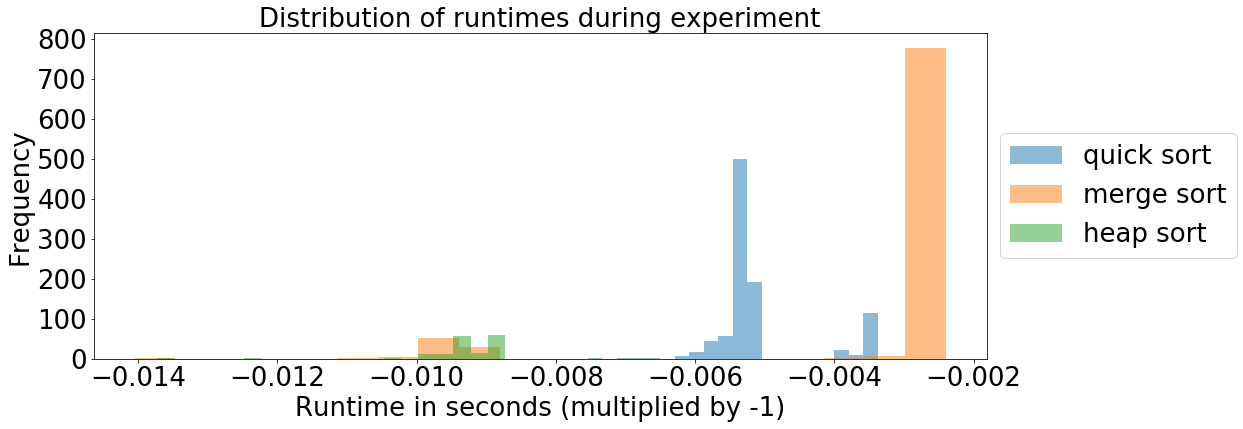

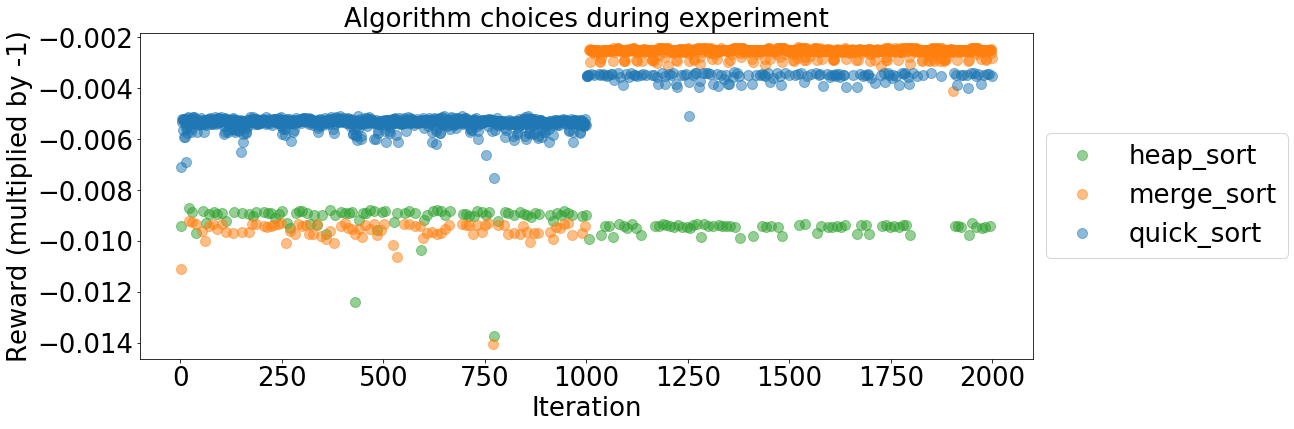

In [151]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 1,quantile = 0.005)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 3, quantile = 0.05

Total reward -8.120295399998213
Number of restarts 11


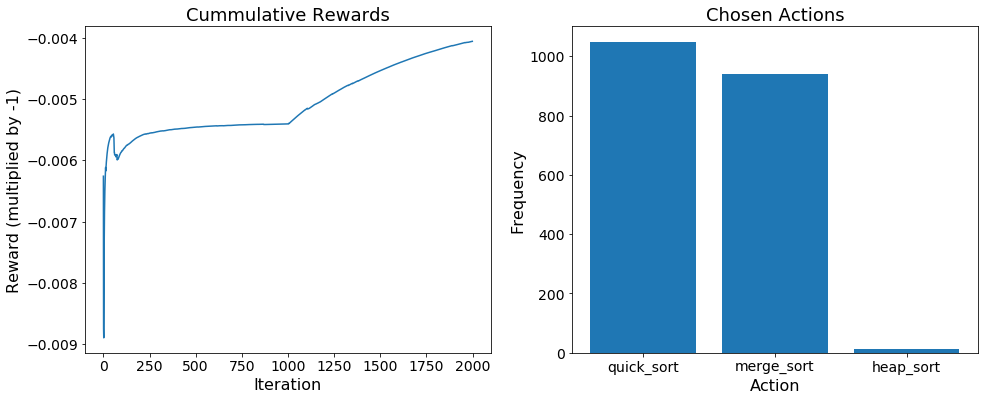

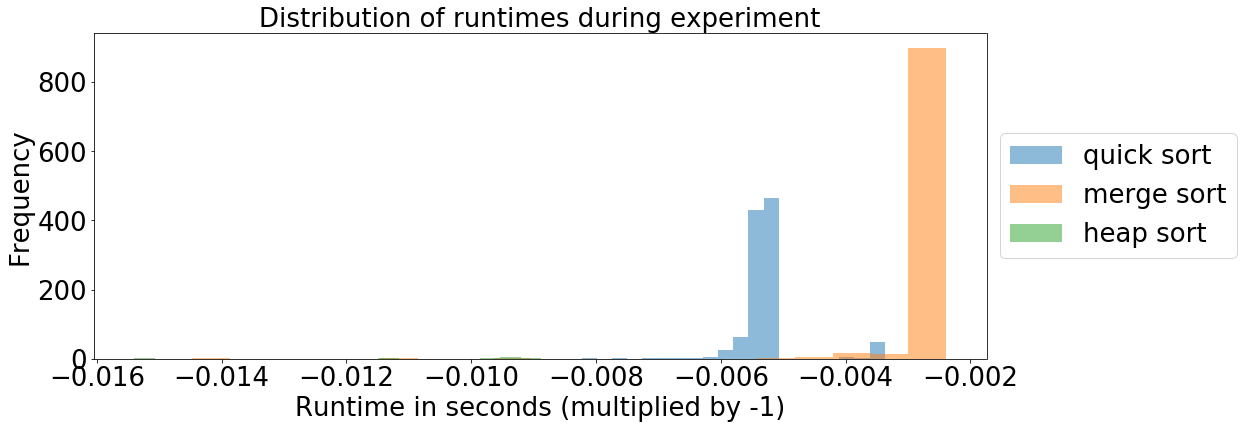

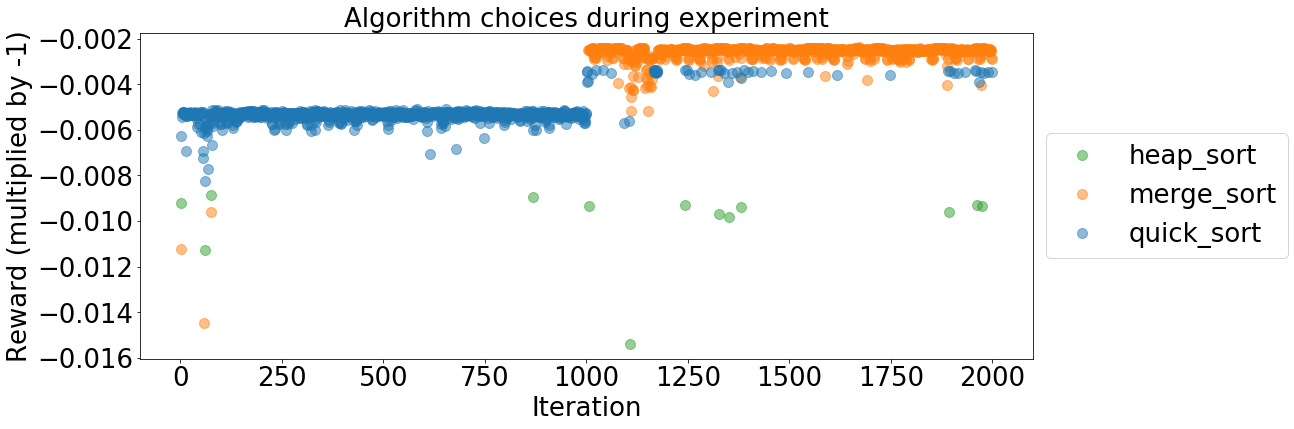

In [152]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 3,quantile = 0.05)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 3, quantile = 0.025

Total reward -7.911448199991355
Number of restarts 2


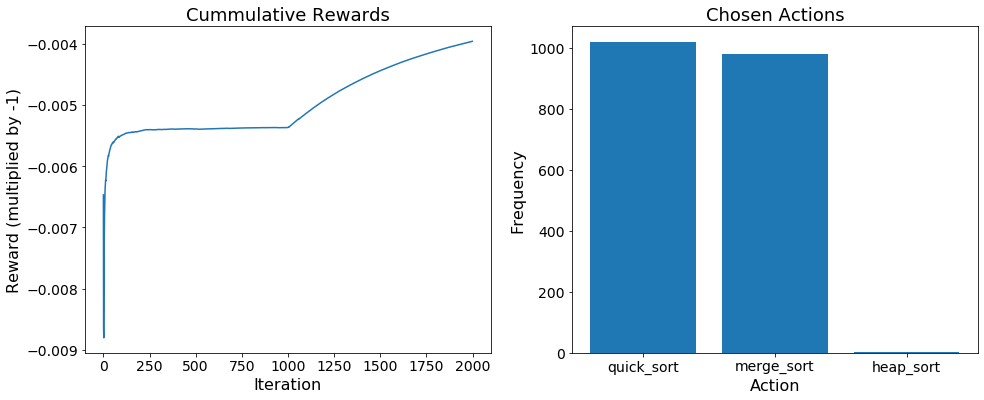

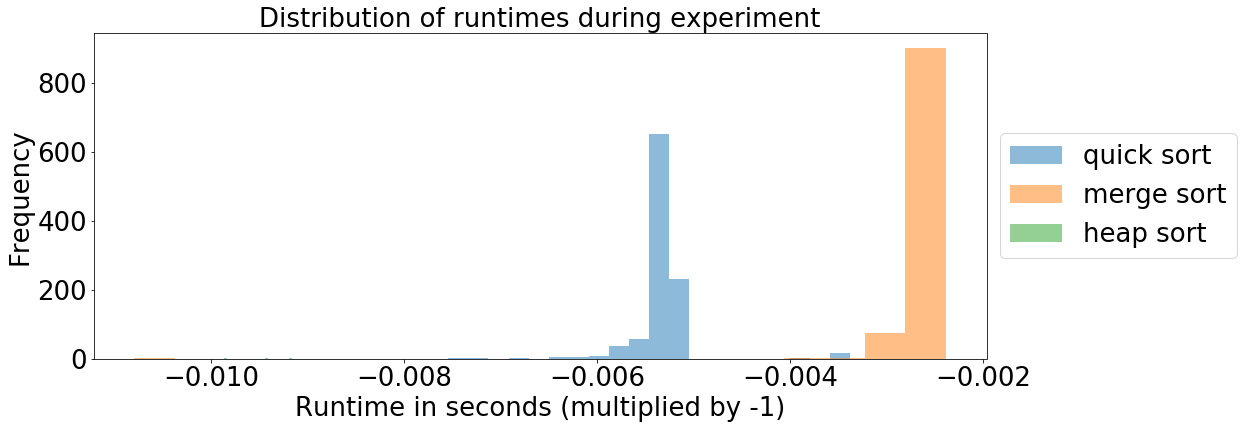

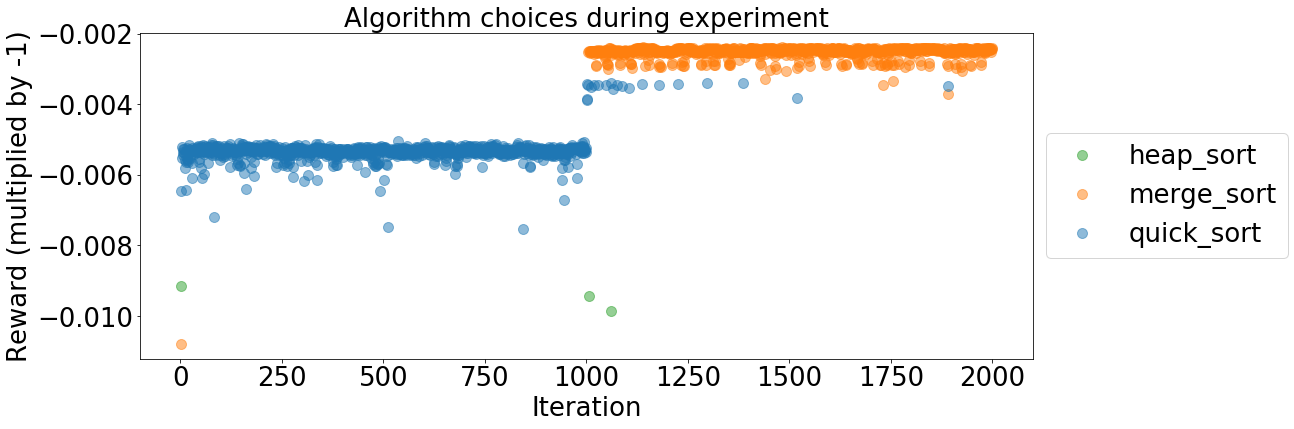

In [153]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 3,quantile = 0.025)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 3, quantile = 0.005

Total reward -8.077753699987625
Number of restarts 2


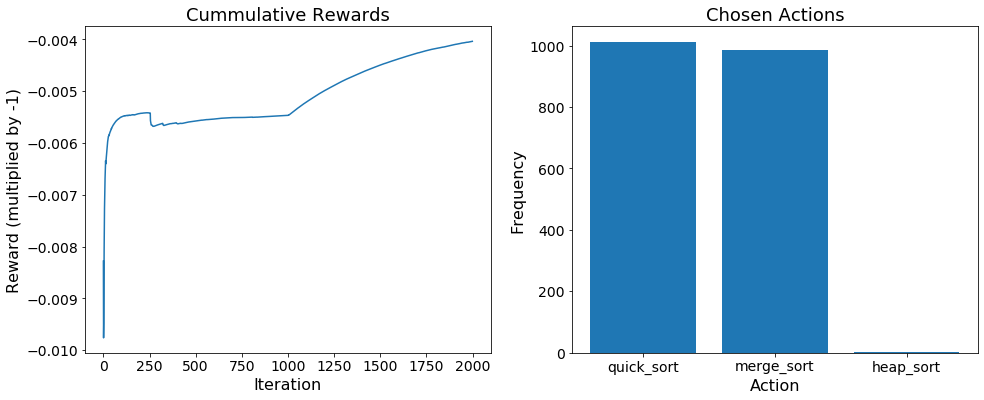

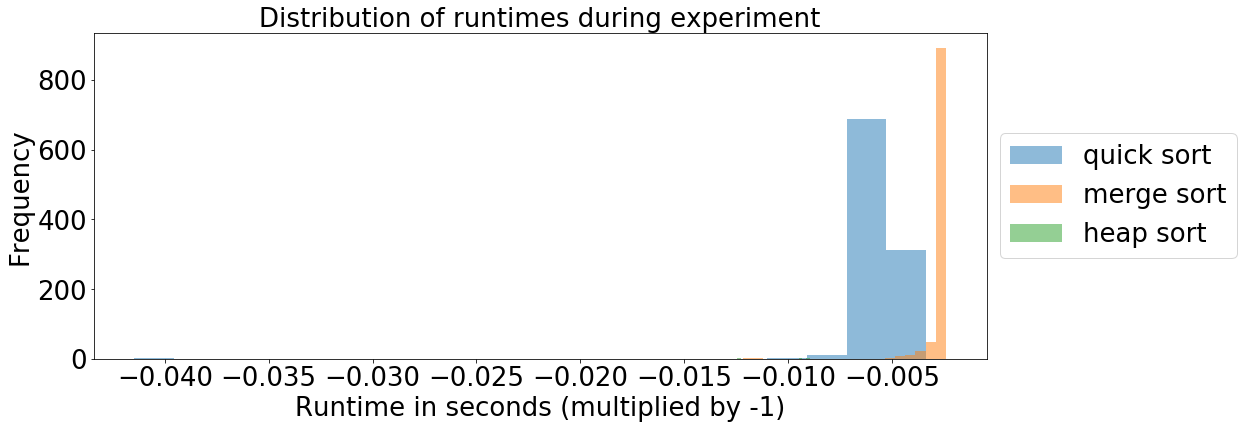

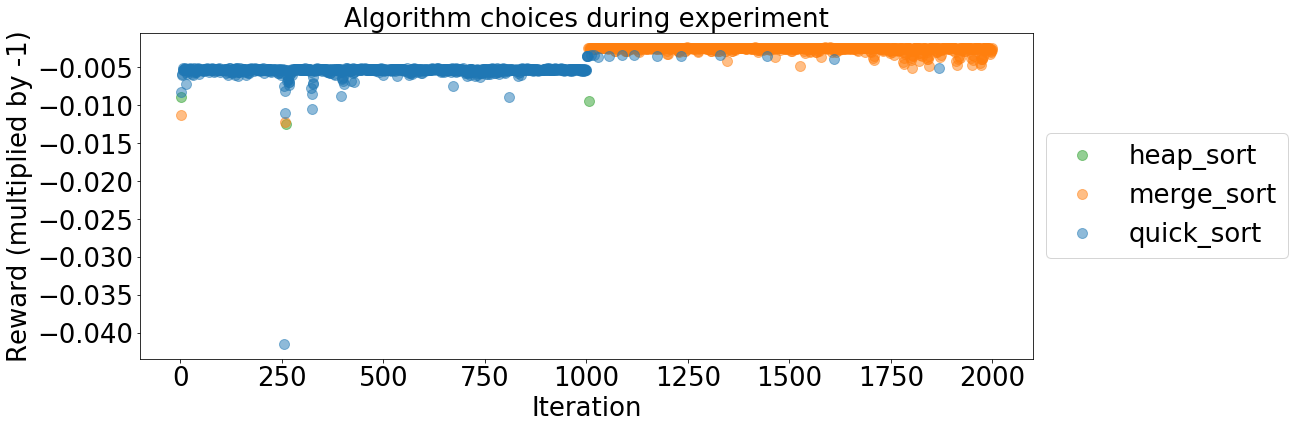

In [154]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 3,quantile = 0.005)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 5, quantile = 0.025

Total reward -8.41288820000591
Number of restarts 3


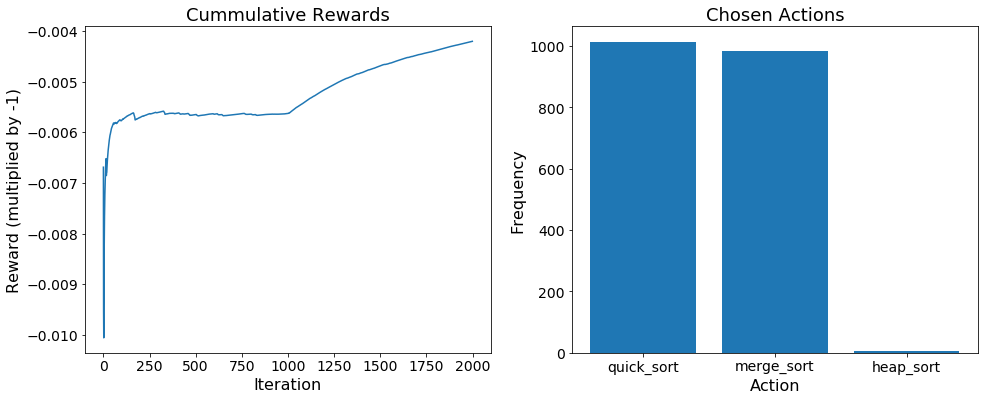

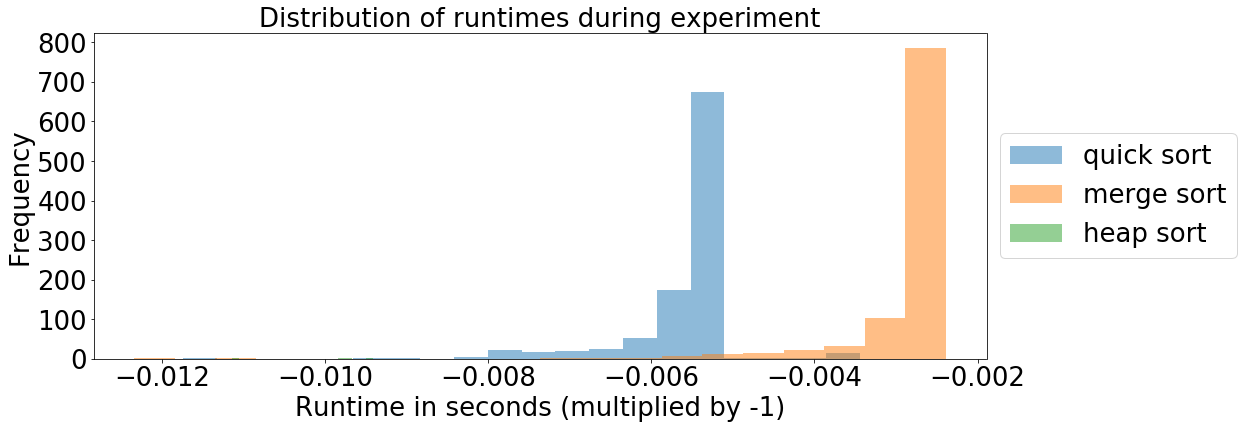

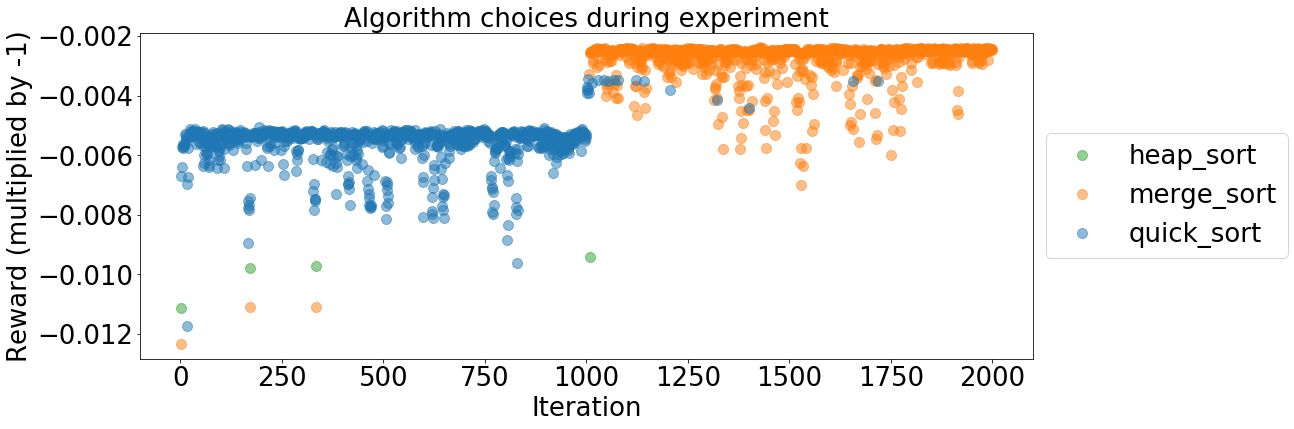

In [155]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 5,quantile = 0.025)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 5, quantile = 0.005

Total reward -8.291978099980042
Number of restarts 1


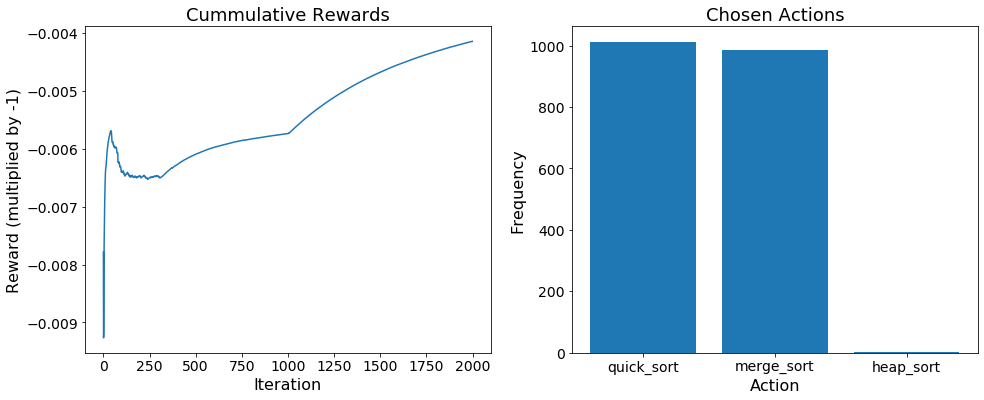

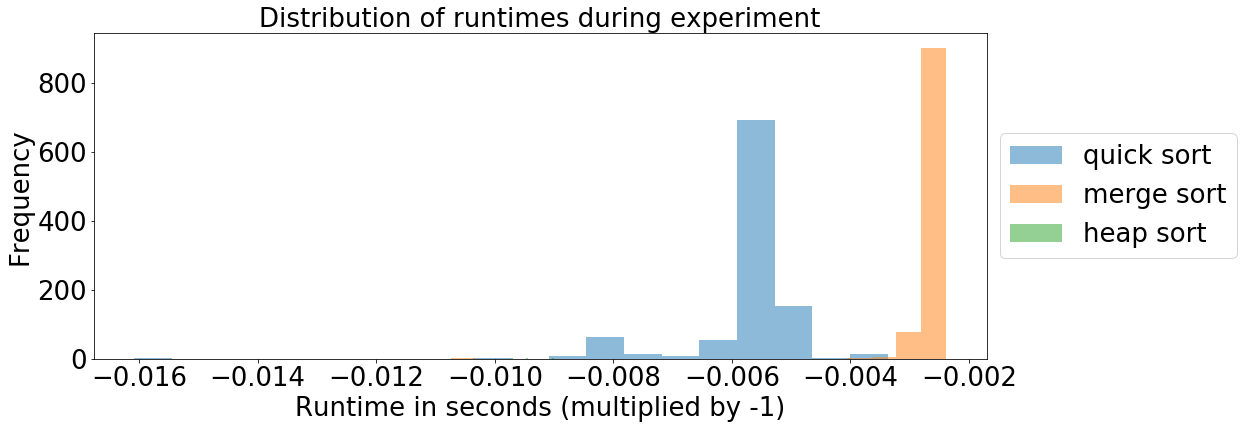

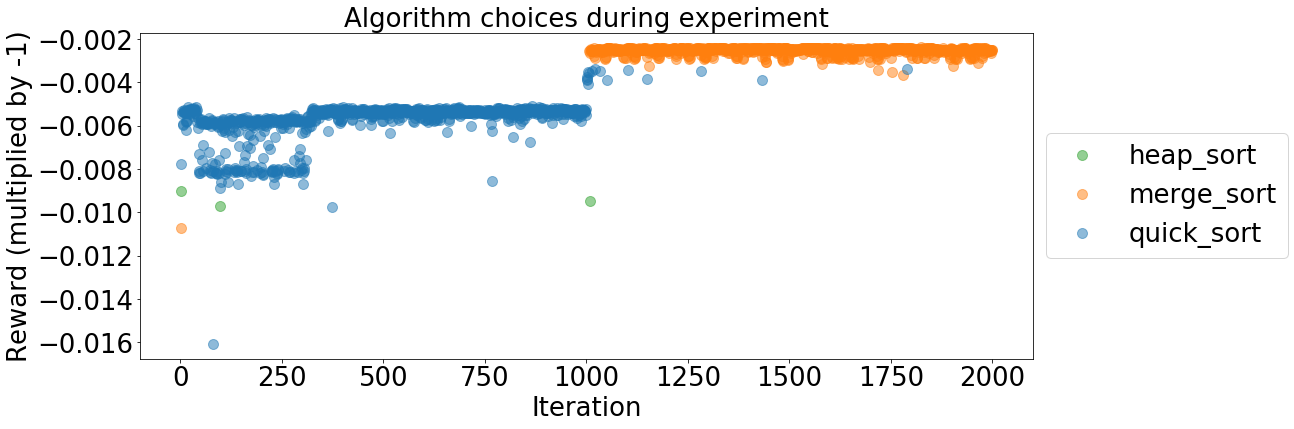

In [156]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 5,quantile = 0.005)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)

#### num_consec_elem = 5, quantile = 0.05

Total reward -7.953832499996679
Number of restarts 1


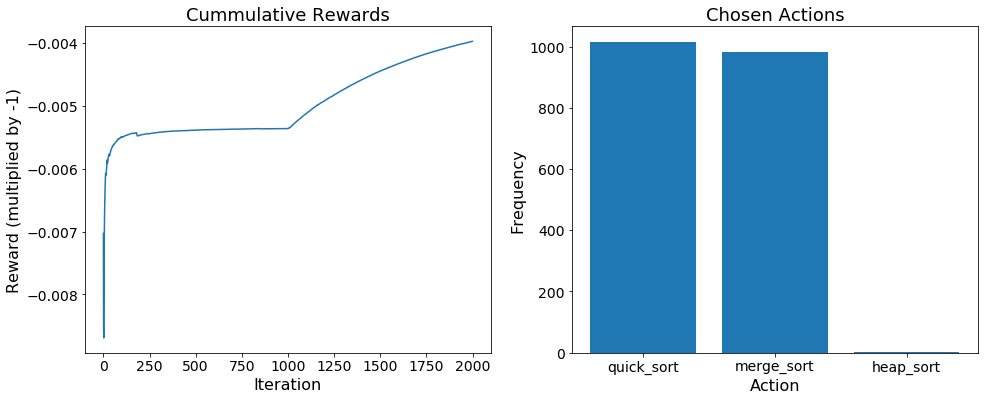

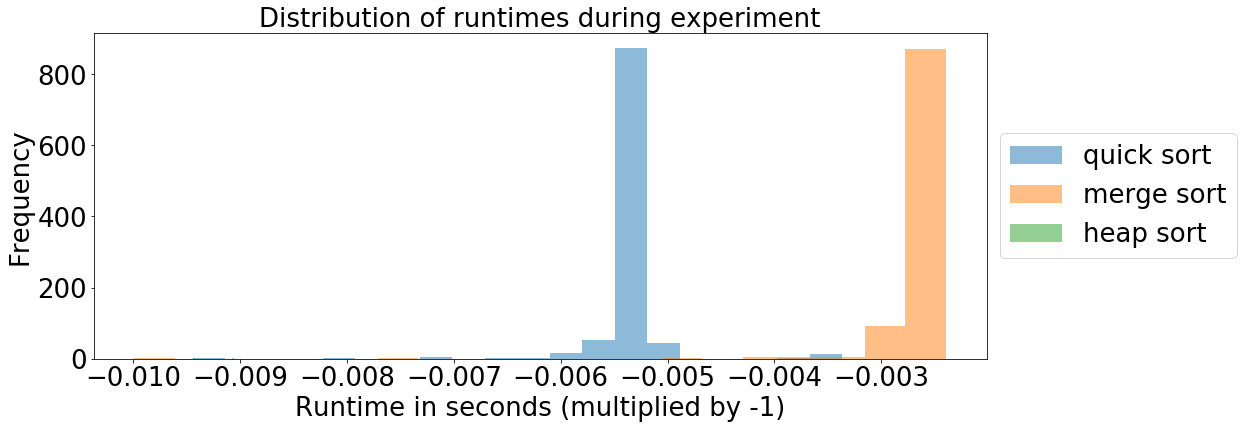

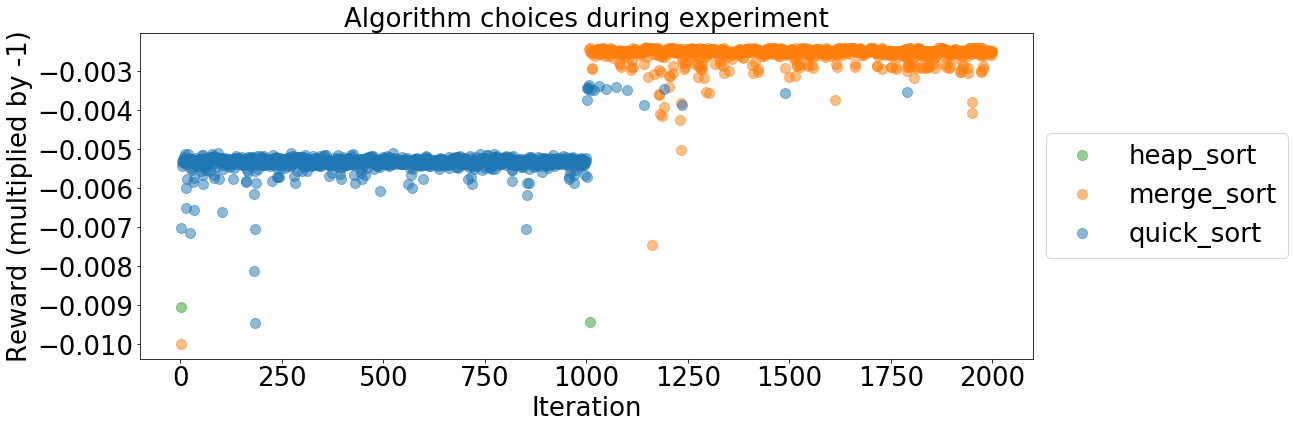

In [157]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history, number_of_restarts, restarts = ucb(list_distributions_1, n_samples_1e5, num_consec_elem = 5,quantile = 0.05)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)
print("Number of restarts", number_of_restarts, "in iterations:", restarts)